## Analysis of RECS data and derive regression models (XGBoost)

DATA Preparation
 - Call generateX from generateXdata.py file to prepare the X data
 - y data is extracted from the raw file

Running data Models
1. Split train and test data (75:25 ratio)
2. Run XGBOOST algo against train data
3. Use Test to validate prediction
4. Plot the residual and accuracy if possible


In [1]:
# IMport dependencies
import pandas as pd
from pandas import set_option
import numpy as np
import os
import csv

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# import required libraries related to xgBoost and sci-kit learn
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# import gridsearch cv for multiple iterations
from sklearn.model_selection import GridSearchCV

# explain xgboost preiction and model
import shap

# from keras.utils import to_categorical

# import preprocessing from sklearn
from sklearn import preprocessing

# DictVectorizer
from sklearn.feature_extraction import DictVectorizer

# import generateXdata.py to prepare the data
from generateXdata_withVocab import generateX


In [2]:
# gobal variables
dataFilePath = "dataforfinalproject"
filename = "RECS_COMBINED_DATA.csv"
cols_file = "Final_Columns_withCat.csv"




### Prepare Data

In [3]:
# obtain features contributing to the Y = BTU or DOllar
X, vocab = generateX(ohe = True, target = "DOLLAR")

 X Features shape : (22591, 87)
y label shape : (22591,)
cols with values as 99 and -2: ['CELLAR', 'STORIES', 'PRKGPLC1', 'BEDROOMS', 'FUELPOOL', 'SIZRFRI1', 'TYPERFR1', 'AGERFRI1', 'SIZRFRI2', 'TYPERFR2', 'AGERFRI2', 'NUMFREEZ', 'SIZFREEZ', 'AGEFRZR', 'STOVENFUEL', 'OVENUSE', 'AMTMICRO', 'DWASHUSE', 'WASHLOAD', 'WASHTEMP', 'EQUIPM', 'FUELHEAT', 'EQUIPAGE', 'PROTHERM', 'TEMPHOME', 'TEMPGONE', 'TEMPNITE', 'AGECENAC', 'USECENAC', 'NUMBERAC', 'WWACAGE', 'USEWWAC', 'FUELH2O', 'WHEATAGE', 'WHEATSIZ', 'LGTOUTNUM', 'ESDISHW', 'PGASHEAT', 'WOODAMT'] 

Duplicate Count : 0
shape of X is (22591, 79)


In [5]:
vocab

['ADQINSUL',
 'AGECENAC',
 'AGEFRZR',
 'AGERFRI1',
 'AGERFRI2',
 'AMTMICRO',
 'BEDROOMS',
 'BTUEL',
 'BTUELCOL',
 'BTUELOTH',
 'BTUELRFG',
 'BTUELSPH',
 'BTUELWTH',
 'BTUFO',
 'CDD65',
 'CELLAR',
 'CUFEETNG',
 'DIVISION',
 'DRAFTY',
 'DWASHUSE',
 'ELECAUX',
 'EMPLOYHH',
 'EQUIPAGE',
 'EQUIPM',
 'ESDISHW',
 'FUELH2O',
 'FUELHEAT',
 'FUELPOOL',
 'GALLONLP',
 'HDD65',
 'HHAGE',
 'HHSEX',
 'HOUSEHOLDER_RACE',
 'LGTOUTNUM',
 'LPWATER',
 'MONEYPY',
 'NCOMBATH',
 'NHAFBATH',
 'NHSLDMEM',
 'NUMBERAC',
 'NUMCFAN',
 'NUMFREEZ',
 'NUMFRIG',
 'NUMMEAL',
 'OCCUPYY',
 'OTHROOMS',
 'OVENUSE',
 'PCOFFEQUIP',
 'PGASHEAT',
 'PHONE',
 'PRKGPLC1',
 'PROTHERM',
 'RECBATH',
 'REGIONC',
 'SIZFREEZ',
 'SIZRFRI1',
 'SIZRFRI2',
 'STORIES',
 'STOVENFUEL',
 'TEMPGONE',
 'TEMPHOME',
 'TEMPNITE',
 'TOTCSQFT',
 'TOTHSQFT',
 'TOTROOMS',
 'TOTUSQFT',
 'TVAUDIOEQUIP',
 'TYPERFR1',
 'TYPERFR2',
 'USECENAC',
 'USEWWAC',
 'WASHLOAD',
 'WASHTEMP',
 'WHEATAGE',
 'WHEATSIZ',
 'WINDOWS',
 'WOODAMT',
 'WWACAGE',
 'YEARMADE']

In [6]:
# y = pd.read_csv(os.path.join(dataFilePath,filename), low_memory = False)['TOTALBTU']
y = pd.read_csv(os.path.join(dataFilePath,filename), low_memory = False)['TOTALDOLLAR']
y.shape

(22591,)

# XGBOOST - Predicting Total Consumption in BTU

In [7]:
#convert the dataset into an optimized data structure called Dmatrix 
#that XGBoost supports and gives it acclaimed performance and efficiency gains. 
data_dmatrix = xgb.DMatrix(data=X,label=y)

### Build base XGBoost model using K-Folds method

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(18072, 79)

In [10]:
# Base Model
xg_reg_base = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.5, learning_rate = 0.05,min_child_weight=1,
                max_depth = 3, alpha = 10, n_estimators = 100, subsample = 0.5, silent = 1)
    
eval_set = [(X_train, y_train), (X_test, y_test)]

xg_reg_base.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)

base_preds = xg_reg_base.predict(X_test)
base_rmse = np.sqrt(mean_squared_error(y_test, base_preds))
base_r2 = xg_reg_base.score(X_test, y_test)

print(f"Base model RMSE : {round(base_rmse,2)}")
print(f"Base model r2 : {round(base_r2*100, 2)} %")

# retrieve performance metrics and plot it
# results = xg_reg_base.evals_result()

# plt = plotRegError_curve(results , "Base Model")

# plt.show()


Base model RMSE : 578.14
Base model r2 : 74.3 %


### Start Fine Tuning

In [11]:
# Step 1: determine n estimator using CV and K-Folds
print("Step 1 of Fine tuning : Determing best n_estimator using CV method.......")
# start with the base model
xg_reg_tune1 = xg_reg_base

print("Determing the best iteration using k-Folds.................\n")
xgb_param = xg_reg_tune1.get_xgb_params()
cvresult = xgb.cv(params = xgb_param, dtrain = data_dmatrix, num_boost_round=300, 
                  nfold=10, metrics='rmse', early_stopping_rounds=20, verbose_eval=False)

print(f"The best iteration obtained using Cross Validation is {cvresult.shape[0]}\n")
xg_reg_tune1.set_params(n_estimators=cvresult.shape[0])

print("Fitting Train data to the model ")
print("----------------------------------------------------------------\n")
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg_tune1.fit(X_train, y_train,eval_metric=["rmse"], eval_set=eval_set, verbose=False)

print("Predicting Y with test data")
print("----------------------------------------------------------------\n")
tune1_preds = xg_reg_tune1.predict(X_test)
tune1_rmse = np.sqrt(mean_squared_error(y_test, tune1_preds))
tune1_r2 = xg_reg_tune1.score(X_test, y_test)

print("Test RMSE after Ist tuning %f" % (tune1_rmse))
print('r2 after first tuning is {:.2f} %'.format(tune1_r2*100))


# # retrieve performance metrics and plot it
# plt = plotRegError_curve(xg_reg_tune1.evals_result(), "After 1st tuning")

# plt.show()

Step 1 of Fine tuning : Determing best n_estimator using CV method.......
Determing the best iteration using k-Folds.................

The best iteration obtained using Cross Validation is 300

Fitting Train data to the model 
----------------------------------------------------------------

Predicting Y with test data
----------------------------------------------------------------

Test RMSE after Ist tuning 478.538137
r2 after first tuning is 0.82 %


In [13]:
# Step 2: determine the best max_depth and min_child_weight
print("Step 2 of Fine tuning : Determing best max_depth and min_child_weight.......")
# start with the base model
xg_reg_tune2 = xg_reg_tune1

#set the list of max depth and min_child_weight we need
param_test1 = {
 'max_depth':range(3,10,5),
 'min_child_weight':range(1,6,2)
}

print("Determing the best iteration using k-Folds.................\n")
gsearch1 = GridSearchCV(estimator = xg_reg_tune2, 
 param_grid = param_test1, scoring='r2',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train, y_train)
print(gsearch1.best_estimator_)
print(f"\nThe best value for max_depth is {gsearch1.best_params_['max_depth']} and \
          best value for min_child_weight is {gsearch1.best_params_['min_child_weight']}")

# set these params to the new model and fit
xg_reg_tune2.set_params(max_depth=gsearch1.best_params_['max_depth'])
xg_reg_tune2.set_params(min_child_weight=gsearch1.best_params_['min_child_weight'])

print("Fitting Train data to the model ")
print("----------------------------------------------------------------\n")
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg_tune2.fit(X_train, y_train,eval_metric=["rmse"], eval_set=eval_set, verbose=False)

print("Predicting Y with test data")
print("----------------------------------------------------------------\n")
tune2_preds = xg_reg_tune2.predict(X_test)
tune2_rmse = np.sqrt(mean_squared_error(y_test, tune2_preds))
tune2_r2 = xg_reg_tune2.score(X_test, y_test)

print("Test RMSE after 2nd tuning %f" % (tune2_rmse))
print('r2 after 2nd tuning is {:.2f} %'.format(tune2_r2*100))


# retrieve performance metrics and plot it
# plt = plotRegError_curve(xg_reg_tune2.evals_result(), "After 2nd tuning")

# plt.show()

Test RMSE after 2nd tuning 464.934001
r2 after 2nd tuning is 0.83 %


In [ ]:
# Step 3: determine the most optimum subsample and colsample_bytree
print("Step 3 of Fine tuning : Determing best subsample and colsample_bytree.......")
# start with the base model
xg_reg_tune3 = xg_reg_tune2

#set the list of subsample and colsample_bytree
param_test3 = {
 'subsample':[0.6, 0.7],
 'colsample_bytree':[0.7, 0.8, 0.9]
}


gsearch1 = GridSearchCV(estimator = xg_reg_tune3, 
 param_grid = param_test3, scoring='r2',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train, y_train)
print(gsearch1.best_estimator_)
print(f"\nThe best value for subsample and colsample_bytree is {gsearch1.best_params_['subsample']}, {gsearch1.best_params_['colsample_bytree']}")

# set these params to the new model and fit
xg_reg_tune3.set_params(subsample=gsearch1.best_params_['subsample'])
xg_reg_tune3.set_params(colsample_bytree=gsearch1.best_params_['colsample_bytree'])

print("Fitting Train data to the model ")
print("----------------------------------------------------------------\n")
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg_tune3.fit(X_train, y_train,eval_metric=["rmse"], eval_set=eval_set, verbose=False)

print("Predicting Y with test data")
print("----------------------------------------------------------------\n")
tune3_preds = xg_reg_tune3.predict(X_test)
tune3_rmse = np.sqrt(mean_squared_error(y_test, tune3_preds))
tune3_r2 = xg_reg_tune3.score(X_test, y_test)

print("Test RMSE after 3rd tuning %f" % (tune3_rmse))
print('r2 after 3rd tuning is {:.2f} %'.format(tune3_r2*100))


# retrieve performance metrics and plot it
# plt = plotRegError_curve(xg_reg_tune3.evals_result(), "After 3rd tuning")

# plt.show()

In [19]:
xg_reg_tune3

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, importance_type='gain',
       learning_rate=0.05, max_delta_step=0, max_depth=8,
       min_child_weight=5, missing=None, n_estimators=300, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7)

In [20]:
# Step 4: determine the best alpha
print("Step 4 of Fine tuning : Determing best alpha.......")
# start with the base model
xg_reg_tune4 = xg_reg_tune3

#set the list of max depth and min_child_weight we need
param_test4 = {
 'alpha':[1e-5, 0.1, 1, 10]
}


gsearch1 = GridSearchCV(estimator = xg_reg_tune4, 
 param_grid = param_test4, scoring='r2',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train, y_train)
print(gsearch1.best_estimator_)
print(f"\nThe best value for alpha is {gsearch1.best_params_['alpha']}")

# set these params to the new model and fit
xg_reg_tune4.set_params(alpha=gsearch1.best_params_['alpha'])

print("Fitting Train data to the model ")
print("----------------------------------------------------------------\n")
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg_tune4.fit(X_train, y_train,eval_metric=["rmse"], eval_set=eval_set, verbose=False)

print("Predicting Y with test data")
print("----------------------------------------------------------------\n")
tune4_preds = xg_reg_tune4.predict(X_test)
tune4_rmse = np.sqrt(mean_squared_error(y_test, tune4_preds))
tune4_r2 = xg_reg_tune4.score(X_test, y_test)

print("Test RMSE after 4th tuning %f" % (tune4_rmse))
print('r2 after fourth tuning is {:.2f} %'.format(tune4_r2*100))


# retrieve performance metrics and plot it
# plt = plotRegError_curve(xg_reg_tune4.evals_result(), "After 4th tuning")

# plt.show()



Step 4 of Fine tuning : Determing best alpha.......
XGBRegressor(alpha=1e-05, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.9, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=5, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7)

The best value for alpha is 1e-05
Fitting Train data to the model 
----------------------------------------------------------------

Predicting Y with test data
----------------------------------------------------------------

Test RMSE after 4th tuning 468.242262
r2 after fourth tuning is 83.14 %


In [21]:
# Step 5: determine the best learning_rate
print("Step 5 of Fine tuning : Determing best learning_rate.......")
# start with the base model

xg_reg_tune5 = xg_reg_tune4
# xg_reg_tune5 = xgb.XGBRegressor(alpha=1e-05, base_score=0.5, booster='gbtree',
#        colsample_bylevel=1, colsample_bytree=0.9, gamma=0.0,
#        importance_type='gain', learning_rate=0.05, max_delta_step=0,
#        max_depth=8, min_child_weight=5, missing=None, n_estimators=100,
#        n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
#        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
#        subsample=0.7)

#set the list of max depth and min_child_weight we need
param_test5 = {
 'learning_rate':[0.05, 0.1, 0.15,0.2, 0.25, 0.3]
}


gsearch1 = GridSearchCV(estimator = xg_reg_tune5, 
 param_grid = param_test5, scoring='r2',n_jobs=4,iid=False, cv=5)

gsearch1.fit(X_train, y_train)
print(gsearch1.best_estimator_)
print(f"\nThe best value for learning_rate is {gsearch1.best_params_['learning_rate']}")

# set these params to the new model and fit
xg_reg_tune5.set_params(learning_rate=gsearch1.best_params_['learning_rate'])

print("Fitting Train data to the model ")
print("----------------------------------------------------------------\n")
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg_tune5.fit(X_train, y_train,eval_metric=["rmse"], eval_set=eval_set, verbose=False)

print("Predicting Y with test data")
print("----------------------------------------------------------------\n")
tune5_preds = xg_reg_tune5.predict(X_test)
tune5_rmse = np.sqrt(mean_squared_error(y_test, tune5_preds))
tune5_r2 = xg_reg_tune5.score(X_test, y_test)

print("Test RMSE after 5th tuning %f" % (tune5_rmse))
print('r2 after 5th tuning is {:.2f} %'.format(tune5_r2*100))


# retrieve performance metrics and plot it
# plt = plotRegError_curve(xg_reg_tune5.evals_result(), "After 5th tuning")

# plt.show()



Step 5 of Fine tuning : Determing best learning_rate.......
XGBRegressor(alpha=1e-05, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.9, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=5, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=1,
       subsample=0.7)

The best value for learning_rate is 0.05
Fitting Train data to the model 
----------------------------------------------------------------

Predicting Y with test data
----------------------------------------------------------------

Test RMSE after 5th tuning 468.242262
r2 after 5th tuning is 83.14 %


In [33]:
final_model = xgb.XGBRegressor(alpha=10, base_score=0.5, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=0.9, gamma=0,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=8, min_child_weight=5, missing=None, n_estimators=300,
       n_jobs=1, nthread=2, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=1,
       subsample=0.7)

In [34]:
eval_set = [(X_train, y_train), (X_test, y_test)]
final_model.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)


# MODEL REPORT

preds_train = final_model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, preds_train))


preds = final_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))


print("Final MODEL REPORT \n")
print("---------------------------------------------------------------------------------------------\n")
print("Train RMSE: %f" % (train_rmse))
print("Test RMSE: %f" % (rmse))
print('The r2 of the xgboost regressor is {:.2f} out of 1 on the training data'.format(final_model.score(X_train, y_train)))
print('The r2 of the xgboost regressor is {:.2f} out of 1 on the test data'.format(final_model.score(X_test, y_test)*100))

MODEL REPORT 

---------------------------------------------------------------------------------------------

Train RMSE: 159.212022
Test RMSE: 459.507977
The r2 of the xgboost regressor is 0.98 out of 1 on the training data
The r2 of the xgboost regressor is 83.77 out of 1 on the test data


## Run the regression model on all data and plot the Y estimated and Y actual

In [37]:
prediction_allY = final_model.predict(X)
# print(prediction_allY.shape[0])
overall_rmse = np.sqrt(mean_squared_error(y, prediction_allY))

print("XGBoost best estimator output for all data\n")
print("---------------------------------------------------------------------")
print("RMSE: %f" % (overall_rmse))
print('The accuracy of the xgboost regressor is {:.2f} out of 1 on the all data'.format(final_model.score(X, y)*100))

XGBoost best estimator output for all data

---------------------------------------------------------------------
RMSE: 250.029739
The accuracy of the xgboost regressor is 94.60 out of 1 on the all data


In [38]:
df_preds = pd.DataFrame(list(zip(list(prediction_allY),list(y))), columns = ["Predicted Price","Actual Price"])
# df_preds['Actual Price'] = y_test
df_preds.shape

(22591, 2)

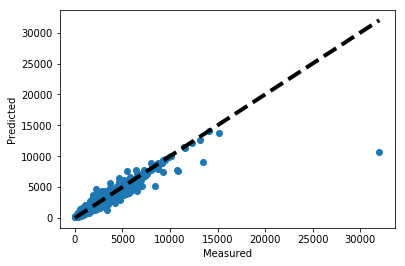

In [43]:
fig,ax = plt.subplots()
ax.scatter(y, prediction_allY)
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
fig.show()

In [62]:
def plotRegError_curve(results,subTxt ):
        
    # retrieve performance metrics and plot it    
    epochs = len(results['validation_1']['rmse'])
    x_axis = range(0, epochs)

    
    # plot regression error
    fig, axs = plt.subplots(figsize = (6,4))
    sns.lineplot(x_axis, results['validation_0']['rmse'], label='Train', ax = axs)
    sns.lineplot(x_axis, results['validation_1']['rmse'], label='Test', ax = axs)
    
    plt.legend()
    plt.ylabel('Regression Error')
    plt.title(f'XGBoost Regression Error - {subTxt}')

    return plt

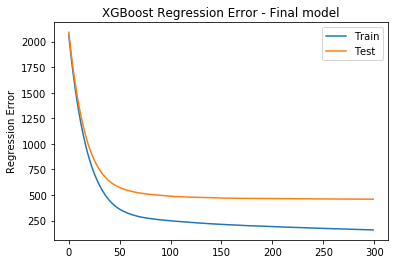

In [63]:
## Regression error plots
plt = plotRegError_curve(final_model.evals_result(), "Final model")

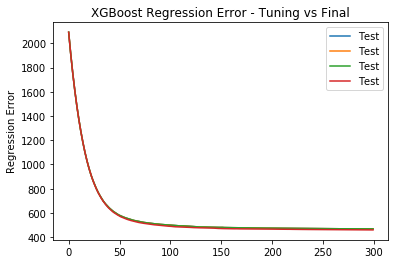

# Using Shap explain the model

In [44]:
# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP values
# (same syntax works for LightGBM, CatBoost, and scikit-learn models)
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X)

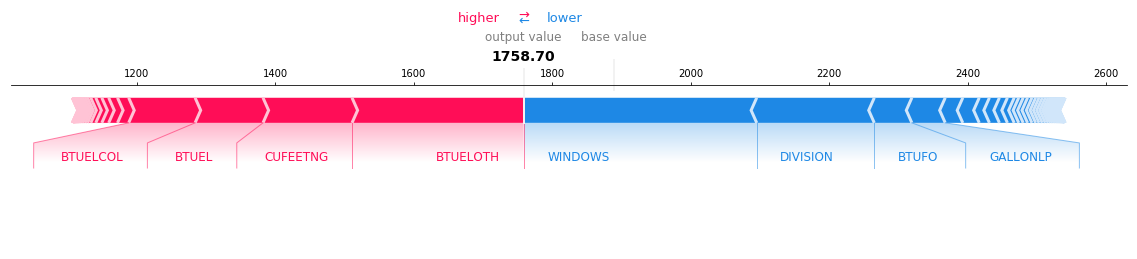

In [65]:
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[1,:], feature_names = vocab, matplotlib = True)

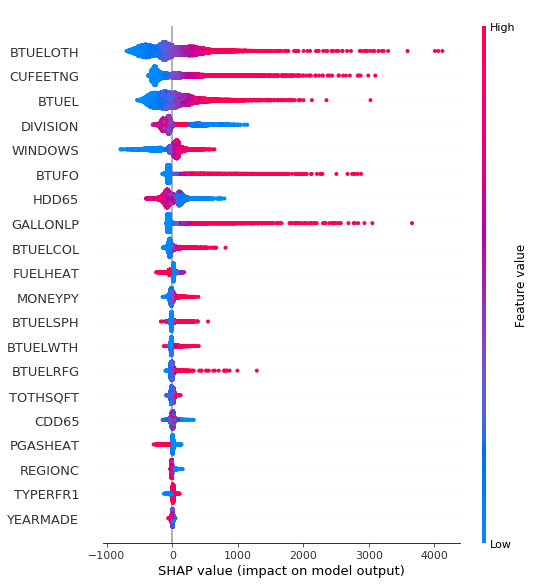

In [66]:
shap.summary_plot(shap_values, X, feature_names = vocab)

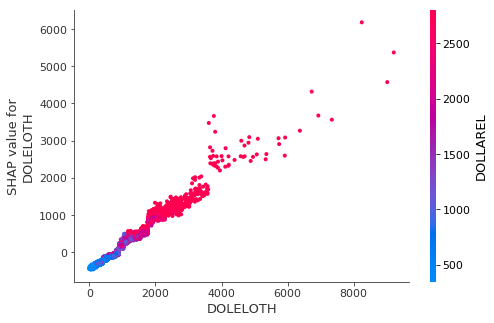

In [21]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("DOLELOTH", shap_values, X, feature_names = vocab)

In [ ]:
shap.image_plot(shap_values, X)


### k-fold Cross Validation using XGBoost
In order to build more robust models, it is common to do a k-fold cross validation where all the entries in the original training dataset are used for both training as well as validation. Also, each entry is used for validation just once. XGBoost supports k-fold cross validation via the cv() method.

In [21]:
params = {"objective":"reg:linear",'colsample_bytree': 0.7,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=500,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123,
                    verbose_eval = False)

In [22]:
print((cv_results["test-rmse-mean"]).tail(1))
cv_results.head()



499    193.940421
Name: test-rmse-mean, dtype: float64


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1960.968726,11.945971,1961.910425,49.630355
1,1775.679785,11.651927,1778.170483,48.489277
2,1610.132910,10.981522,1613.985694,47.788973
3,1461.236767,10.386246,1466.698315,47.950497
4,1326.756152,8.991017,1333.656201,48.737901


### Visualise the results

In [22]:
feat_imp_df  = pd.DataFrame(list(zip(vocab, xg_reg.feature_importances_)), columns = ['Feature','Importance'])
feat_imp_df.sort_values(['Importance'], ascending = False, inplace = True)
feat_imp_df.head()

,Feature,Importance
19,DOLELOTH,0.451363
68,TOTALBTU,0.084932
23,DOLLAREL,0.081883
32,FUELHEAT,0.027669
10,BTUELRFG,0.027411


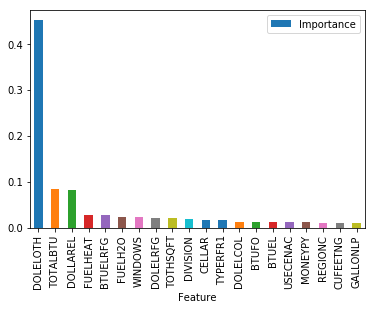

In [23]:
feat_imp_df[:20].plot(x = "Feature", y = "Importance", kind = "bar")

In [24]:
xg_reg1 = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

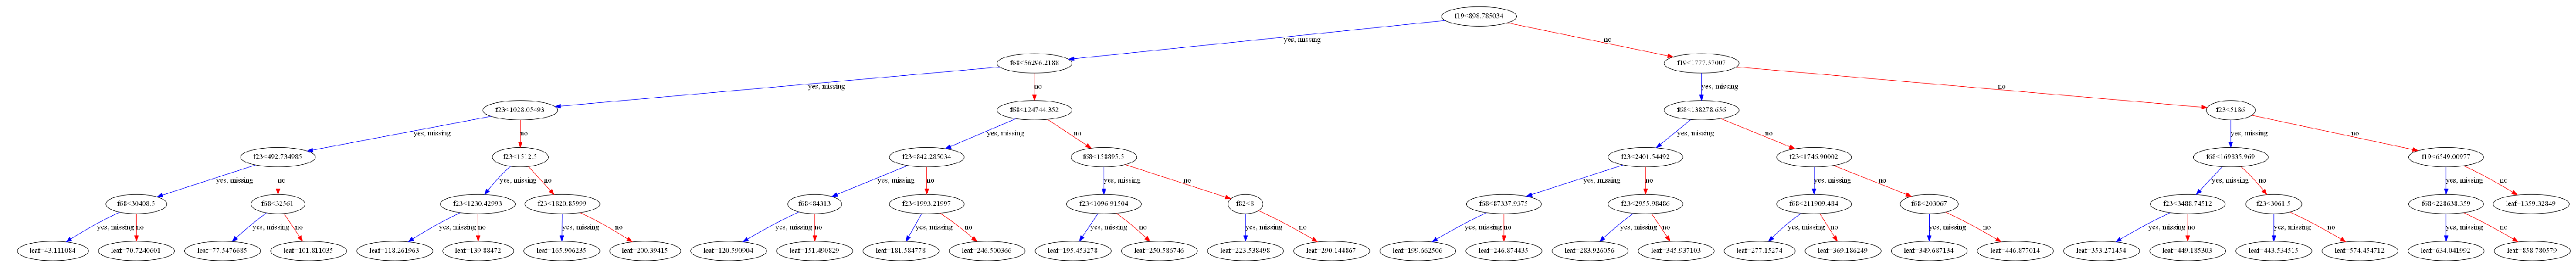

In [30]:
xgb.plot_tree(xg_reg1,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.savefig(os.path.join("output","xgboost_decisiontree.png"))
plt.show()


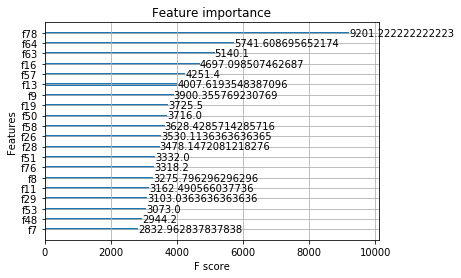

In [28]:
xgb.plot_importance(xg_reg,max_num_features = 20, importance_type = "cover")
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

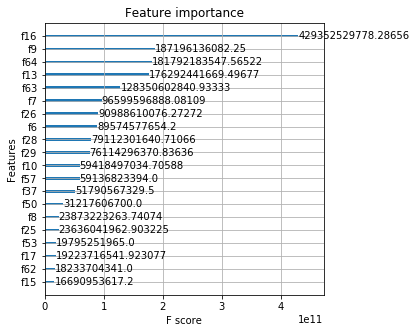

In [30]:
xgb.plot_importance(xg_reg,max_num_features = 20, importance_type = "gain")
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

### Using Eval Metric and looking at the learning curve

In [34]:
xg_reg_2 = xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.6, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 70)

In [54]:
eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg_2.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=True)

[0]	validation_0-rmse:1960.23	validation_1-rmse:1963.19
[1]	validation_0-rmse:1775.18	validation_1-rmse:1774.75
[2]	validation_0-rmse:1610.44	validation_1-rmse:1609.5
[3]	validation_0-rmse:1462.15	validation_1-rmse:1460.59
[4]	validation_0-rmse:1326.4	validation_1-rmse:1322.76
[5]	validation_0-rmse:1207.57	validation_1-rmse:1202.02
[6]	validation_0-rmse:1102.74	validation_1-rmse:1096.12
[7]	validation_0-rmse:1003.06	validation_1-rmse:995.363
[8]	validation_0-rmse:918.703	validation_1-rmse:910.459
[9]	validation_0-rmse:837.69	validation_1-rmse:828.809
[10]	validation_0-rmse:765.145	validation_1-rmse:755.952
[11]	validation_0-rmse:704.972	validation_1-rmse:695.08
[12]	validation_0-rmse:648.652	validation_1-rmse:638.699
[13]	validation_0-rmse:603.142	validation_1-rmse:594.041
[14]	validation_0-rmse:556.717	validation_1-rmse:548.414
[15]	validation_0-rmse:518.329	validation_1-rmse:510.498
[16]	validation_0-rmse:481.209	validation_1-rmse:473.673
[17]	validation_0-rmse:446.673	validation_1-r

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.6, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=70, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [45]:
# make predictions for test data
y_pred = xg_reg_2.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))
print(f"accuracy % is : {round(xg_reg_2.score(X_test, y_test)*100, 2)}")

RMSE: 186.832638
accuracy % is : 96.82


In [37]:
results = xg_reg_2.evals_result()
print(results)

{'validation_0': {'error': [-1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.371826, -1875.

In [47]:
# retrieve performance metrics
results = xg_reg_2.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

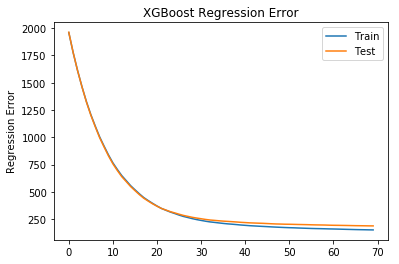

In [53]:
# plot regression error
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('Regression Error')
plt.title('XGBoost Regression Error')
plt.show()

In [15]:
# # BASE MODEL ---- OLD CODE
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.8, learning_rate = 0.1,min_child_weight=1,
#                 max_depth = 3, alpha = 10, n_estimators = 120, subsample = 0.8, silent = 1, seed = 123)

# eval_set = [(X_train, y_train), (X_test, y_test)]
# xg_reg.fit(X_train, y_train, eval_metric=["rmse"], eval_set=eval_set, verbose=False)


# # MODEL REPORT

# preds_train = xg_reg.predict(X_train)
# train_rmse = np.sqrt(mean_squared_error(y_train, preds_train))


# preds = xg_reg.predict(X_test)
# rmse = np.sqrt(mean_squared_error(y_test, preds))


# print("MODEL REPORT \n")
# print("---------------------------------------------------------------------------------------------\n")
# print("Train RMSE: %f" % (train_rmse))
# print("Test RMSE: %f" % (rmse))
# print('The accuracy of the xgboost regressor is {:.2f} out of 1 on the training data'.format(xg_reg.score(X_train, y_train)))
# print('The accuracy of the xgboost regressor is {:.2f} out of 1 on the test data'.format(xg_reg.score(X_test, y_test)))

# # retrieve performance metrics and plot it
# results = xg_reg.evals_result()
# epochs = len(results['validation_0']['rmse'])
# x_axis = range(0, epochs)

# # plot regression error
# fig, axs = plt.subplots(figsize = (10,8))
# sns.lineplot(x_axis, results['validation_0']['rmse'], label='Train', ax = axs)
# sns.lineplot(x_axis, results['validation_1']['rmse'], label='Test', ax = axs)
# plt.legend()
# plt.ylabel('Regression Error')
# plt.title('XGBoost Regression Error')

# plt.show()

# # RESIDUAL PLOT
# plt.scatter(xg_reg.predict(X_train), xg_reg.predict(X_train) - y_train, c="blue", label="Training Data")
# plt.scatter(xg_reg.predict(X_test), xg_reg.predict(X_test) - y_test, c="orange", label="Testing Data")
# plt.legend()
# plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
# plt.title("Residual Plot")
# plt.show()